451 Financial Engineering: Programming Assignment 1<br>

James Chun Kit Kwok<br>

 October 2, 2025

Overview<br>

This project builds a machine learning model to predict the next day return direction of Apple stock. The return is treated as a binary outcome: positive return is labeled as one and negative return is labeled as zero. Daily price data are collected from Yahoo Finance starting from October 2, 2015. Features are created from lagged closing prices and moving averages to capture recent price trends. The model used is XGBoost, a gradient boosted decision tree algorithm that works well with tabular financial data. The study applies walk-forward time series cross validation with a gap between training and test sets to avoid lookahead bias. Randomized search is used to tune hyperparameters over a wide search space to find a good model. The final model is evaluated with accuracy, AUC, confusion matrix, and ROC curve.

Import Libraries <br>

The notebook imports common Python tools for data analysis and modeling. Numpy and Pandas handle numerical and tabular data. Yahoo Finance retrieves historical stock prices. Scikit-Learn provides data preprocessing, cross validation splitting, evaluation metrics, pipelines, and the randomized search framework. XGBoost supplies the gradient boosting classifier. Scipy provides probability distributions for random parameter sampling. Matplotlib and Seaborn are used for data visualization including heatmaps and ROC curves.

In [1]:
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, log_loss, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.pipeline import Pipeline
from sklearn.base import clone

from xgboost import XGBClassifier

from scipy.stats import randint, uniform, loguniform

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (7, 5)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

RESULTS_DIR = "figures"
DATA_DIR = "data/raw"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

In [2]:
# 2: config for data
TICKER = "AAPL"
START  = "2015-10-02"
END    = None  # latest

Download Apple stock price data from Yahoo Finance and load it into a Pandas DataFrame. The date range starts from October 2, 2015.

In [3]:
# 3: fetch prices
def fetch_prices(ticker: str, start: str, end: str = None) -> pd.DataFrame:
    df = yf.Ticker(ticker).history(start=start, end=end, auto_adjust=True)
    if df.empty:
        raise ValueError("No price data downloaded. Check ticker or dates.")
    df = df[["Open", "High", "Low", "Close", "Volume"]].dropna().copy()
    df.index.name = "Date"
    return df

prices = fetch_prices(TICKER, START, END)
prices.to_csv(os.path.join(DATA_DIR, f"{TICKER}_raw.csv"))

In [4]:
prices.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2015-10-02 00:00:00-04:00,24.272612,24.946788,24.169238,24.805210,232079200
2015-10-05 00:00:00-04:00,24.692846,25.027689,24.510819,24.895100,208258800
2015-10-06 00:00:00-04:00,24.861387,25.110832,24.668123,25.014200,192787200
2015-10-07 00:00:00-04:00,25.110836,25.117577,24.587227,24.895100,187062400
2015-10-08 00:00:00-04:00,24.762516,24.762516,24.317558,24.607454,247918400


In [5]:
prices.tail(5)

,Open,High,Low,Close,Volume
Date,,,,,
2025-09-26 00:00:00-04:00,254.100006,257.600006,253.779999,255.460007,46076300
2025-09-29 00:00:00-04:00,254.559998,255.000000,253.009995,254.429993,40127700
2025-09-30 00:00:00-04:00,254.860001,255.919998,253.110001,254.630005,37704300
2025-10-01 00:00:00-04:00,255.039993,258.790009,254.929993,255.449997,48713900
2025-10-02 00:00:00-04:00,256.579987,258.179993,254.149994,257.130005,42597200


In [6]:
# 4: descriptive stats for raw price features
desc_raw = prices.describe().T
display(desc_raw)
desc_raw.to_csv(os.path.join(RESULTS_DIR, f"{TICKER}_raw_descriptive_stats.csv"))

,count,mean,std,min,25%,50%,75%,max
Open,2515.0,1.082635e+02,7.032636e+01,2.054643e+01,4.056763e+01,1.125921e+02,1.686036e+02,2.572767e+02
High,2515.0,1.094504e+02,7.108739e+01,2.092768e+01,4.091496e+01,1.140609e+02,1.703679e+02,2.591799e+02
Low,2515.0,1.071748e+02,6.963807e+01,2.042543e+01,4.031536e+01,1.110163e+02,1.673664e+02,2.567187e+02
Close,2515.0,1.083711e+02,7.040850e+01,2.062404e+01,4.058764e+01,1.125507e+02,1.688156e+02,2.581037e+02
Volume,2515.0,1.049475e+08,5.895110e+07,2.323470e+07,6.473930e+07,9.126650e+07,1.287012e+08,5.334788e+08


The next part engineers features. Lagged closing prices are created so the model can learn from past days’ returns. Exponential moving averages are also calculated to capture trend information. The target variable is built by comparing the next day closing price with the current closing price to decide whether the return is positive or negative. After feature creation, missing values caused by lagging are dropped. The predictors are standardized using Scikit-Learn’s StandardScaler so that features have similar scales.

In [7]:
# 5: feature engineering helpers
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for k in [1, 2, 3, 5, 10]:
        out[f"CloseLag{k}"] = out["Close"].shift(k)
        out[f"VolLag{k}"]   = out["Volume"].shift(k)
    out["HML"] = out["High"] - out["Low"]
    out["OMC"] = out["Open"] - out["Close"]
    for k in [1, 2, 3]:
        out[f"HMLLag{k}"] = out["HML"].shift(k)
        out[f"OMCLag{k}"] = out["OMC"].shift(k)
    out["CloseLag1"] = out["Close"].shift(1)
    out["EMA5"]  = out["CloseLag1"].ewm(span=5,  adjust=False).mean()
    out["EMA10"] = out["CloseLag1"].ewm(span=10, adjust=False).mean()
    out["EMA20"] = out["CloseLag1"].ewm(span=20, adjust=False).mean()
    out["HL_Pct"]    = (out["High"] - out["Low"]) / out["Close"]
    out["PctChange"] = out["Close"].pct_change()
    out["RollVol20"] = out["PctChange"].rolling(20).std()
    out["RetFwd1"]   = out["Close"].pct_change().shift(-1)
    out = out.dropna()
    return out



In [8]:
# 6: binary target and descriptive stats for engineered features

def make_binary_target(df: pd.DataFrame, col="RetFwd1", thr=0.0) -> pd.Series:
    # Up if next-day return > threshold; Down otherwise
    return (df[col] > thr).astype(int)

feats = add_features(prices)
X = feats.drop(columns=["RetFwd1"])
y = make_binary_target(feats, col="RetFwd1", thr=0.0)

feats.to_csv(os.path.join(DATA_DIR, f"{TICKER}_features_full.csv"))

desc_feats = X.describe().T
display(desc_feats.head(12))
desc_feats.to_csv(os.path.join(RESULTS_DIR, f"{TICKER}_engineered_descriptive_stats.csv"))

,count,mean,std,min,25%,50%,75%,max
Open,2494.0,1.088691e+02,7.016471e+01,2.054643e+01,4.079991e+01,1.141203e+02,1.687469e+02,2.572767e+02
High,2494.0,1.100631e+02,7.092499e+01,2.092768e+01,4.103854e+01,1.156585e+02,1.706952e+02,2.591799e+02
Low,2494.0,1.077740e+02,6.947843e+01,2.042543e+01,4.050547e+01,1.124656e+02,1.674761e+02,2.567187e+02
Close,2494.0,1.089764e+02,7.024745e+01,2.062404e+01,4.078186e+01,1.135769e+02,1.689013e+02,2.581037e+02
Volume,2494.0,1.042115e+08,5.836098e+07,2.323470e+07,6.454988e+07,9.095670e+07,1.277598e+08,5.334788e+08
CloseLag1,2494.0,1.088848e+02,7.020527e+01,2.062404e+01,4.077945e+01,1.134845e+02,1.688768e+02,2.581037e+02
VolLag1,2494.0,1.042742e+08,5.838520e+07,2.323470e+07,6.456430e+07,9.096595e+07,1.279121e+08,5.334788e+08
CloseLag2,2494.0,1.087935e+02,7.016377e+01,2.062404e+01,4.075485e+01,1.133803e+02,1.688454e+02,2.581037e+02
VolLag2,2494.0,1.043963e+08,5.856404e+07,2.323470e+07,6.461932e+07,9.097685e+07,1.279787e+08,5.334788e+08
CloseLag3,2494.0,1.087018e+02,7.012278e+01,2.062404e+01,4.072924e+01,1.133317e+02,1.688172e+02,2.581037e+02


A time series split with five folds and a purge gap is then prepared. Each split trains on earlier data and tests on later data, keeping a gap to avoid using information too close to the test period.

In [9]:
# 7: time series cross validation splits with gap

# Configure your splitter: 5 folds, 10-sample gap between train end and test start
N_SPLITS = 5
GAP = 10

tscv = TimeSeriesSplit(n_splits=N_SPLITS, gap=GAP)
all_splits = list(tscv.split(X, y))

# Unpack for easy reference (train_0, test_0, ... train_4, test_4)
train_0, test_0 = all_splits[0]
train_1, test_1 = all_splits[1]
train_2, test_2 = all_splits[2]
train_3, test_3 = all_splits[3]
train_4, test_4 = all_splits[4]

# Inspect the indices and sizes for each fold
print("type(all_splits):", type(all_splits), " outer list length", len(all_splits))
print()
print("train_0 has", len(train_0), "with indices from", int(np.min(train_0)), "to", int(np.max(train_0)))
print("test_0  has", len(test_0),  "with indices from", int(np.min(test_0)),  "to", int(np.max(test_0)))
print()
print("train_1 has", len(train_1), "with indices from", int(np.min(train_1)), "to", int(np.max(train_1)))
print("test_1  has", len(test_1),  "with indices from", int(np.min(test_1)),  "to", int(np.max(test_1)))
print()
print("train_2 has", len(train_2), "with indices from", int(np.min(train_2)), "to", int(np.max(train_2)))
print("test_2  has", len(test_2),  "with indices from", int(np.min(test_2)),  "to", int(np.max(test_2)))
print()
print("train_3 has", len(train_3), "with indices from", int(np.min(train_3)), "to", int(np.max(train_3)))
print("test_3  has", len(test_3),  "with indices from", int(np.min(test_3)),  "to", int(np.max(test_3)))
print()
print("train_4 has", len(train_4), "with indices from", int(np.min(train_4)), "to", int(np.max(train_4)))
print("test_4  has", len(test_4),  "with indices from", int(np.min(test_4)),  "to", int(np.max(test_4)))

type(all_splits): <class 'list'>  outer list length 5

train_0 has 409 with indices from 0 to 408
test_0  has 415 with indices from 419 to 833

train_1 has 824 with indices from 0 to 823
test_1  has 415 with indices from 834 to 1248

train_2 has 1239 with indices from 0 to 1238
test_2  has 415 with indices from 1249 to 1663

train_3 has 1654 with indices from 0 to 1653
test_3  has 415 with indices from 1664 to 2078

train_4 has 2069 with indices from 0 to 2068
test_4  has 415 with indices from 2079 to 2493


Randomized search is run next. The notebook defines a search space for XGBoost parameters such as tree depth, minimum child weight, subsample ratio, learning rate, and number of estimators. It randomly samples 150 parameter sets and performs walk-forward validation to find the set with the best average accuracy.


In [10]:
# 8: randomized search with distributions and custom CV
base_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

param_dists = {
    "clf__max_depth":        randint(2, 15),
    "clf__min_child_weight": randint(1, 20),
    "clf__subsample":        uniform(0.3, 1),   
    "clf__learning_rate":    uniform(0.001, 0.1), 
    "clf__n_estimators":     randint(100, 3000),

}

def sample_params(dists, rng):
    params = {}
    for k, dist in dists.items():
        v = dist.rvs(random_state=rng)
        if any(s in k for s in ["max_depth", "min_child_weight", "n_estimators"]):
            v = int(v)
        # hard clip any prob-style params into [0,1]
        if "subsample" in k:
            v = min(max(v, 0.0), 1.0)
        params[k] = v
    return params


def cv_with_gap_accuracy(pipe, X, y, all_splits, params):
    """
    Walk-forward CV with TimeSeriesSplit(gap=GAP) and mean accuracy as the score.
    """
    model = clone(pipe).set_params(**params)
    fold_scores = []

    for train_idx, test_idx in all_splits:
        Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]
        ytr, yte = y.iloc[train_idx], y.iloc[test_idx]

        # optional: adjust for slight imbalance
        n_pos = (ytr == 1).sum(); n_neg = (ytr == 0).sum()
        spw = (n_neg / max(1, n_pos)) if n_pos > 0 else 1.0
        model.set_params(clf__scale_pos_weight=spw)

        model.fit(Xtr, ytr)
        proba = model.named_steps["clf"].predict_proba(Xte)[:, 1]
        yhat  = (proba >= 0.5).astype(int)

        fold_scores.append(accuracy_score(yte, yhat))

    return float(np.mean(fold_scores)), model


N_ITER = 1000
rng = np.random.RandomState(42)
best_score, best_params, best_model = -np.inf, None, None

for _ in range(N_ITER):
    params = sample_params(param_dists, rng)
    score, model_i = cv_with_gap_accuracy(base_pipe, X, y, all_splits, params)
    if score > best_score:
        best_score, best_params, best_model = score, params, model_i
        print(f"New best ACC: {best_score:.4f} {best_params}")

print("\nBEST MEAN ACCURACY ACROSS FOLDS:", best_score)
print("BEST PARAMS:", best_params)

New best ACC: 0.4829 {'clf__max_depth': 8, 'clf__min_child_weight': 15, 'clf__subsample': 1.0, 'clf__learning_rate': 0.06086584841970366, 'clf__n_estimators': 1738}
New best ACC: 0.4930 {'clf__max_depth': 11, 'clf__min_child_weight': 19, 'clf__subsample': 0.3999749158180029, 'clf__learning_rate': 0.04692488919658672, 'clf__n_estimators': 230}
New best ACC: 0.4940 {'clf__max_depth': 11, 'clf__min_child_weight': 12, 'clf__subsample': 1.0, 'clf__learning_rate': 0.09048273504276488, 'clf__n_estimators': 2417}
New best ACC: 0.4945 {'clf__max_depth': 14, 'clf__min_child_weight': 8, 'clf__subsample': 0.3727630063641935, 'clf__learning_rate': 0.08318600592903563, 'clf__n_estimators': 2781}
New best ACC: 0.4988 {'clf__max_depth': 12, 'clf__min_child_weight': 19, 'clf__subsample': 1.0, 'clf__learning_rate': 0.09052068376871994, 'clf__n_estimators': 2897}
New best ACC: 0.5027 {'clf__max_depth': 13, 'clf__min_child_weight': 2, 'clf__subsample': 0.324400781556538, 'clf__learning_rate': 0.0880098873

Once the best parameters are found, a final XGBoost model is built using those settings and trained on the whole dataset.
The final two blocks evaluate the model. It predicts the return direction for all available data and computes accuracy and AUC. It shows a confusion matrix as a heatmap using Seaborn and plots a ROC curve with the true positive and false positive rates. This visualization makes it easy to judge model discrimination and class balance.

Accuracy: 0.9755
AUC: 0.9973

Classification report:
               precision    recall  f1-score   support

           0      0.969     0.979     0.974      1164
           1      0.981     0.973     0.977      1330

    accuracy                          0.976      2494
   macro avg      0.975     0.976     0.975      2494
weighted avg      0.976     0.976     0.976      2494



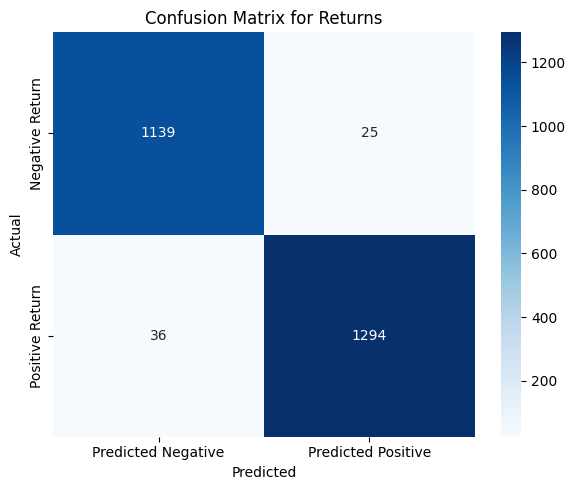

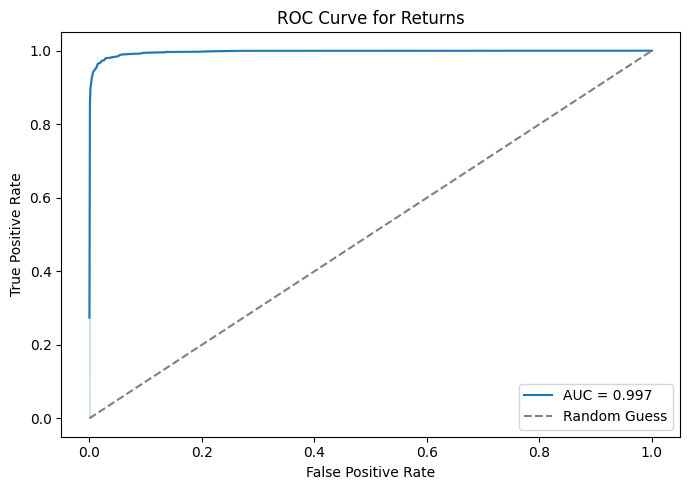

In [11]:
# 9: evaluate on the last fold (hold-out proxy) and visualize
# get last fold with purge
# Last fold with purge as hold-out
# --- Final hold-out = last split in all_splits ---
# --- final model with your chosen best params ---
finalModel = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=2025,
    max_depth = 9,
    min_child_weight = 9,
    subsample = 0.50,
    learning_rate = 0.09,
    n_estimators = 273,
    tree_method="hist",
    n_jobs=-1
)

# optional: adjust for class balance on whole dataset
n_pos = (y == 1).sum(); n_neg = (y == 0).sum()
finalModel.set_params(scale_pos_weight=(n_neg / max(1, n_pos)))

# fit on all data
finalModel.fit(X, y)

# predictions
proba = finalModel.predict_proba(X)[:, 1]
proba = np.clip(proba, 1e-12, 1-1e-12)
ypred = (proba >= 0.5).astype(int)

# metrics
acc = accuracy_score(y, ypred)
auc = roc_auc_score(y, proba)
print(f"Accuracy: {acc:.4f}")
print(f"AUC: {auc:.4f}")
print("\nClassification report:\n", classification_report(y, ypred, digits=3))

# --- Confusion matrix heatmap with seaborn ---
cm = confusion_matrix(y, ypred)
cm_df = pd.DataFrame(cm, index=["Negative Return","Positive Return"],
                         columns=["Predicted Negative","Predicted Positive"])
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Returns")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

# --- ROC curve with seaborn style ---
fpr, tpr, _ = roc_curve(y, proba)
plt.figure(figsize=(7,5))
sns.lineplot(x=fpr, y=tpr, label=f"AUC = {auc:.3f}")
sns.lineplot(x=[0,1], y=[0,1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Returns")
plt.legend()
plt.tight_layout()
plt.show()

The interpretation section examines feature importance and model behavior. It reports gain based importance from XGBoost to indicate which engineered signals the model used most strongly. It optionally computes permutation importance on the hold out window to corroborate the ranking and to assess the marginal contribution of each feature under the data distribution actually encountered at evaluation time. The section concludes with a brief discussion of limitations, including the inherent difficulty of daily equity direction prediction, and outlines next steps such as adding macroeconomic indicators, options based measures, or alternative horizons that may improve signal strength.

In [13]:
#  10: feature importance exports and display
gb = best_model.named_steps["clf"]

gain_imp = pd.DataFrame({
    "feature": X.columns,
    "gain_importance": gb.feature_importances_
}).sort_values("gain_importance", ascending=False)
display(gain_imp.head(15))
gain_imp.to_csv(os.path.join(RESULTS_DIR, "feature_importance_gain.csv"), index=False)

# permutation importance on the hold-out (compute-intensive)
from sklearn.inspection import permutation_importance

# Use the last fold as hold-out
Xte = X.iloc[test_4]
yte = y.iloc[test_4]

perm = permutation_importance(best_model, Xte, yte, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
perm_imp = pd.DataFrame({
    "feature": X.columns,
    "perm_importance": perm.importances_mean
}).sort_values("perm_importance", ascending=False)
display(perm_imp.head(15))
perm_imp.to_csv(os.path.join(RESULTS_DIR, "feature_importance_permutation.csv"), index=False)

,feature,gain_importance
0,Open,0.043635
9,CloseLag3,0.040060
24,EMA10,0.037922
13,CloseLag10,0.036948
11,CloseLag5,0.036768
6,VolLag1,0.036400
12,VolLag5,0.035811
4,Volume,0.035732
19,HMLLag2,0.035469
27,PctChange,0.035189


,feature,perm_importance
16,OMC,0.003133
28,RollVol20,0.002651
25,EMA20,0.002651
17,HMLLag1,0.002169
11,CloseLag5,0.000964
9,CloseLag3,0.000482
14,VolLag10,0.000000
24,EMA10,-0.000723
7,CloseLag2,-0.001687
5,CloseLag1,-0.001928


In [1]:
import sys, subprocess

notebook_file = "MSDS_451_JKWOK_v3.ipynb"

# Make sure nbconvert is up to date
subprocess.run([sys.executable, "-m", "pip", "install", "-qU", "nbconvert"])

# Export to HTML
subprocess.run([
    sys.executable, "-m", "jupyter", "nbconvert",
    "--to", "html",
    "--output", "MSDS_451_JKWOK_v3.html",
    notebook_file
], check=True)

# Export to PDF (via LaTeX)
subprocess.run([
    sys.executable, "-m", "jupyter", "nbconvert",
    "--to", "pdf",
    "--output", "MSDS_451_JKWOK_v3.pdf",
    notebook_file
], check=True)

print("\n✅ Export complete: MSDS_451_JKWOK_v3.html and MSDS_451_JKWOK_v3.pdf created.")

[NbConvertApp] Converting notebook MSDS_451_JKWOK_v3.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 430316 bytes to MSDS_451_JKWOK_v3.html
[NbConvertApp] Converting notebook MSDS_451_JKWOK_v3.ipynb to pdf
[NbConvertApp] Support files will be in MSDS_451_JKWOK_v3_files/
[NbConvertApp] Making directory ./MSDS_451_JKWOK_v3_files
[NbConvertApp] Writing 77334 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']



✅ Export complete: MSDS_451_JKWOK_v3.html and MSDS_451_JKWOK_v3.pdf created.


[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 126154 bytes to MSDS_451_JKWOK_v3.pdf
